In [1]:
import torch
import math
import matplotlib.pyplot as plt
import gpytorch
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import pandas as pd

C:\Users\jmadinn\AppData\Local\Temp\ipykernel_27552\2537344704.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
start = time.time()
if (torch.cuda.is_available()):
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

In [4]:
fineSpringConstants = pd.read_csv("fineSpringParameters.csv",header=None)

In [5]:
timesteps = pd.read_csv("timesteps.csv",header=None)

In [6]:
coarseSpringConstants = np.arange(0.1,51.1,5)
mediumSpringConstants = np.arange(0.1,51.1,1)

In [7]:
fineDisplacements = pd.read_csv("fineDisplacements.csv",header=None)

In [8]:
fineDisplacements.set_index(fineSpringConstants.to_numpy().squeeze(),inplace=True)

In [9]:
fineDisplacements.columns = timesteps.to_numpy().squeeze()

In [10]:
coarseDisplacements = fineDisplacements.loc[coarseSpringConstants]

In [11]:
mediumDisplacements = fineDisplacements.loc[mediumSpringConstants]

In [12]:
inputFeatures = np.meshgrid(timesteps, coarseSpringConstants)

In [13]:
xt = np.stack((inputFeatures[1],inputFeatures[0]),axis=-1).reshape((-1,2))

In [14]:
train_x = torch.from_numpy(xt)
train_x.to(device)

tensor([[ 0.1000,  0.0000],
        [ 0.1000,  0.1000],
        [ 0.1000,  0.2000],
        ...,
        [50.1000, 59.8000],
        [50.1000, 59.9000],
        [50.1000, 60.0000]], device='cuda:0', dtype=torch.float64)

In [15]:
yt = coarseDisplacements.to_numpy().flatten()

In [16]:
train_y = torch.from_numpy(yt)
train_y.to(device)

tensor([0.0000, 0.0050, 0.0197,  ..., 0.0200, 0.0200, 0.0200], device='cuda:0',
       dtype=torch.float64)

In [17]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood.to(device)
model = ExactGPModel(train_x, train_y, likelihood)
#model.to(device)

In [18]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.215   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.127   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.051   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.982   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 0.918   lengthscale: 0.910   noise: 0.513
Iter 6/50 - Loss: 0.856   lengthscale: 0.969   noise: 0.474
Iter 7/50 - Loss: 0.791   lengthscale: 1.029   noise: 0.437
Iter 8/50 - Loss: 0.737   lengthscale: 1.090   noise: 0.402
Iter 9/50 - Loss: 0.679   lengthscale: 1.151   noise: 0.370
Iter 10/50 - Loss: 0.626   lengthscale: 1.214   noise: 0.340
Iter 11/50 - Loss: 0.572   lengthscale: 1.276   noise: 0.311
Iter 12/50 - Loss: 0.520   lengthscale: 1.339   noise: 0.285
Iter 13/50 - Loss: 0.471   lengthscale: 1.402   noise: 0.261
Iter 14/50 - Loss: 0.423   lengthscale: 1.465   noise: 0.238
Iter 15/50 - Loss: 0.367   lengthscale: 1.527   noise: 0.217
Iter 16/50 - Loss: 0.313   lengthscale: 1.590   noise: 0.198
Iter 17/50 - Loss: 0.268   length

In [19]:
testFeatures = np.meshgrid(timesteps,mediumSpringConstants)

In [20]:
test_x = torch.from_numpy(np.stack((testFeatures[1],testFeatures[0]),axis=-1).reshape((-1,2)))
test_x.to(device)

tensor([[ 0.1000,  0.0000],
        [ 0.1000,  0.1000],
        [ 0.1000,  0.2000],
        ...,
        [50.1000, 59.8000],
        [50.1000, 59.9000],
        [50.1000, 60.0000]], device='cuda:0', dtype=torch.float64)

In [21]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(): #gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [22]:
end = time.time()
print("Time elapsed",start-end)

Time elapsed -1556.8863773345947


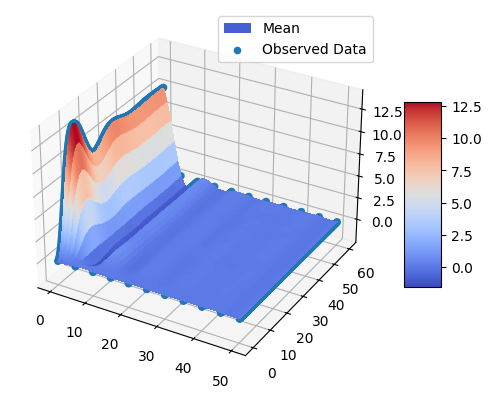

In [49]:
with torch.no_grad():
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    #fig = plt.figure()
    #ax = Axes3D(fig)
    surf = ax.plot_trisurf(test_x[0:,0].numpy(), test_x[0:,1].numpy(),observed_pred.mean.numpy(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    #plt.imshow(z)
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(train_x[0:,0].numpy(),train_x[0:,1].numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    #ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend([ 'Mean','Observed Data'])
    plt.show()
    

array([ 0.1,  0.1,  0.1, ..., 50.1, 50.1, 50.1])